# CTC Loss with OCR

References
* https://en.wikipedia.org/wiki/Connectionist_temporal_classification
* https://keras.io/examples/vision/captcha_ocr/#model
* https://distill.pub/2017/ctc/

In [1]:
# https://jref.com/resources/ms-gothic.53/
#!wget https://jref.com/resources/ms-gothic.53/download
#!unzip msgothic.zip

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageOps
import tensorflow as tf
from difflib import SequenceMatcher

try:
    # Japanese language support for matplotlib.
    import japanize_matplotlib
except:
    !pip install japanize_matplotlib
    import japanize_matplotlib
    
try:
    DEVICE_NAME = tf.test.gpu_device_name()
    print("Found GPU at: {}".format(DEVICE_NAME))
except:
    DEVICE_NAME = "/device:CPU:0"
    print("ERROR: Not connected to a GPU runtime.")

Found GPU at: /device:GPU:0


In [3]:
# Make train-valid-test splits of images and labels.
N_train = 10000
N_valid = 2000
N_test = 2000

# Image dimensions.
height = 32
width = 256

# Character list used to create the data.
#chars = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
#chars = "アイウエオカキクケコサシスセソタチツテトナニヌネノハヒフヘホマミムメモヤユヨラリルレロワヲン"
chars = "ｱｲｳｴｵｶｷｸｹｺｻｼｽｾｿﾀﾁﾂﾃﾄﾅﾆﾇﾈﾉﾊﾋﾌﾍﾎﾏﾐﾑﾒﾓﾔﾕﾖﾗﾘﾙﾚﾛﾜｦﾝ"

chars = sorted([c for c in chars])

# Character to index map and reverse map.
char_to_ind = tf.keras.layers.StringLookup(vocabulary = list(chars), mask_token = None)
ind_to_char = tf.keras.layers.StringLookup(vocabulary = char_to_ind.get_vocabulary(), mask_token = None, invert = True)

#font = ImageFont.truetype("Humor-Sans.ttf", 24)
font = ImageFont.truetype("./msgothic.ttc", 24)

In [4]:
def make_data(N_samples, min_len = 4, max_len = 10):
    X = []
    y = []
    # Create N_samples samples of features X and labels y.
    for i in range(N_samples):
        # Each image contains randomly generated text with random length [4, 10].
        N = np.random.randint(min_len, max_len + 1)
        text = np.random.choice(chars, N)
        text = "".join(text)

        # Randomly jitter the position of the text in the image.
        # Do not jitter the y coordinate! Only the x-coordinate (i.e. the time coordinate)
        # should be jittered.
        pos = (0 + np.random.randint(0, 122 + (max_len - len(text)) * 12), 5)
        image = Image.new("RGB", [width, height], (0, 0, 0))
        d = ImageDraw.Draw(image)
        d.text(pos, text, font = font, fill = (255, 255, 255), anchor = "lm")
        image = ImageOps.grayscale(image)
        image = np.array(image)

        X.append(image.reshape((height, width, 1)))
        # Make all texts the same length (i.e. max_len). 
        # Also ensure no white space before text.
        # These spaces will be converted to zeros by the encoder. 
        text = text.strip()
        pad = (max_len - len(text)) * " "
        y.append(text + pad)

    return np.array(X), np.array(y)

In [5]:
X_train, y_train = make_data(N_train)
X_valid, y_valid = make_data(N_valid)
X_test, y_test = make_data(N_test)

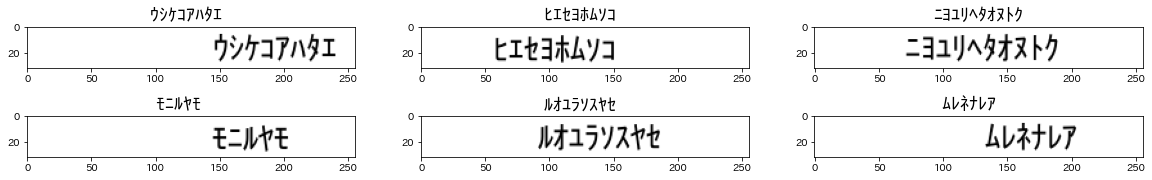

In [6]:
plt.figure(figsize = (20, 3))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(X_train[i][:, :, 0], cmap = "binary")
    plt.title(y_train[i], fontsize = 18)
plt.show()

In [7]:
batch_size = 20
def encode_data(image, label):
    image = tf.keras.layers.Rescaling(1.0 / 255)(image)
    image = tf.transpose(image, perm = [1, 0, 2])
    label = char_to_ind(tf.strings.unicode_split(label,
                                input_encoding = "UTF-8"))
    return {"image": image, "label": label}

with tf.device(DEVICE_NAME):
    train_ds = tf.data.Dataset.from_tensor_slices((X_train,
                                                   y_train))
    train_ds = train_ds.map(encode_data,
               num_parallel_calls = tf.data.AUTOTUNE)
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.prefetch(buffer_size = tf.data.AUTOTUNE)
    valid_ds = tf.data.Dataset.from_tensor_slices((X_valid,
                                                   y_valid))
    valid_ds = valid_ds.map(encode_data,
               num_parallel_calls = tf.data.AUTOTUNE)
    valid_ds = valid_ds.batch(batch_size)
    valid_ds = valid_ds.prefetch(buffer_size = tf.data.AUTOTUNE)
    test_ds = tf.data.Dataset.from_tensor_slices((X_test,
                                                  y_test))
    test_ds = test_ds.map(encode_data,
              num_parallel_calls = tf.data.AUTOTUNE)
    test_ds = test_ds.batch(batch_size)
    test_ds = test_ds.prefetch(buffer_size = tf.data.AUTOTUNE)

In [8]:
class CTCLayer(tf.keras.layers.Layer):
    def __init__(self, name = None):
        super().__init__(name = name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype = "int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype = "int64")
        input_length = input_length * tf.ones(shape = (batch_len, 
                                             1), dtype = "int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype = "int64")
        label_length = label_length * tf.ones(shape = (batch_len, 
                                             1), dtype = "int64")
        loss = self.loss_fn(y_true, y_pred, 
                input_length, label_length)
        self.add_loss(loss)
        return y_pred

def make_model(width, height):
    input_img = tf.keras.layers.Input(shape = (width, height, 1), 
                              name = "image", dtype = "float32")
    labels = tf.keras.layers.Input(name = "label", 
               shape = (None,), dtype = "float32")

    x = tf.keras.layers.Conv2D(32, (3, 3), activation = "relu", 
                              kernel_initializer = "he_normal",
                  padding = "same", name = "Conv1")(input_img)
    x = tf.keras.layers.MaxPooling2D((2, 2), name = "pool1")(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation = "relu", 
                              kernel_initializer = "he_normal",
                           padding = "same", name = "Conv2")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), name = "pool2")(x)

    new_shape = ((width // 4), (height // 4) * 64)
    x = tf.keras.layers.Reshape(target_shape = new_shape, 
                                     name = "reshape")(x)
    x = tf.keras.layers.Dense(64, activation = "relu", 
                                   name = "dense1")(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, 
                   return_sequences = True, dropout = 0.25))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, 
                  return_sequences = True, dropout = 0.25))(x)

    x = tf.keras.layers.Dense(len(char_to_ind.get_vocabulary())+1, 
                       activation = "softmax", name = "dense2")(x)

    output = CTCLayer(name = "ctc_loss")(labels, x)

    model = tf.keras.models.Model(inputs = [input_img, labels], 
                       outputs = output, name = "ocr_model_v1")
    opt = tf.keras.optimizers.Adam()
    model.compile(optimizer = opt)
    return model

with tf.device(DEVICE_NAME):
    model = make_model(width, height)

In [9]:
epochs = 50

history = model.fit(train_ds, validation_data = valid_ds, epochs = epochs)

Epoch 1/50
500/500 [==============================] - 29s 42ms/step - loss: 31.7467 - val_loss: 29.4689
Epoch 2/50
500/500 [==============================] - 19s 39ms/step - loss: 28.7423 - val_loss: 29.0827
Epoch 3/50
500/500 [==============================] - 20s 40ms/step - loss: 28.4975 - val_loss: 28.8252
Epoch 4/50
500/500 [==============================] - 19s 37ms/step - loss: 28.3562 - val_loss: 28.7021
Epoch 5/50
500/500 [==============================] - 19s 37ms/step - loss: 28.2253 - val_loss: 28.6805
Epoch 6/50
500/500 [==============================] - 19s 38ms/step - loss: 28.2525 - val_loss: 28.5327
Epoch 7/50
500/500 [==============================] - 19s 37ms/step - loss: 27.9018 - val_loss: 28.2739
Epoch 8/50
500/500 [==============================] - 19s 38ms/step - loss: 27.7541 - val_loss: 28.2369
Epoch 9/50
500/500 [==============================] - 19s 37ms/step - loss: 27.7081 - val_loss: 28.2388
Epoch 10/50
500/500 [==============================] - 18s 37ms/

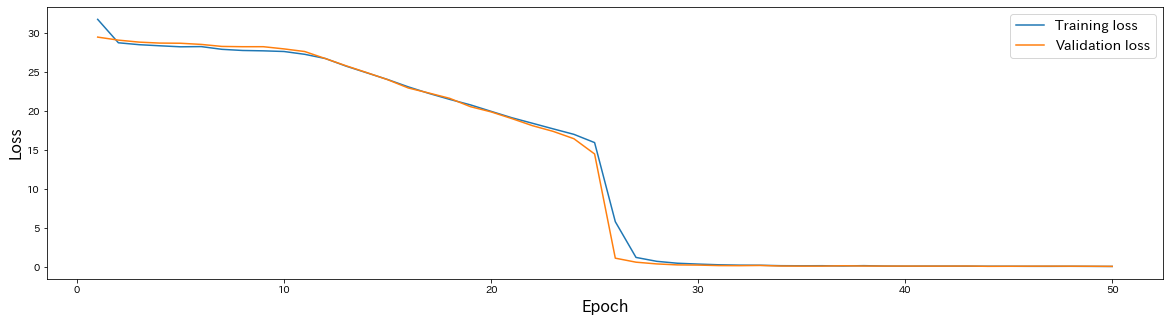

In [15]:
plt.figure(figsize = (20, 5))
plt.plot(range(1, len(history.history["loss"]) + 1),
         history.history["loss"])
plt.plot(range(1, len(history.history["val_loss"]) + 1),
         history.history["val_loss"])
plt.xlabel("Epoch", fontsize = 16)
plt.ylabel("Loss", fontsize = 16)
plt.legend(["Training loss", "Validation loss"], fontsize = 14)
plt.show()

In [16]:
prediction_model = tf.keras.models.Model(
                   model.get_layer(name = "image").input, 
                   model.get_layer(name = "dense2").output)

max_length = 10

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = tf.keras.backend.ctc_decode(pred, 
                      input_length = input_len, 
           greedy = True)[0][0][:, :max_length]

    output_text = []
    for res in results:
        res = tf.strings.reduce_join(ind_to_char(res))
        res = res.numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [18]:
y_pred = []
y_true = []
for batch in test_ds:
    batch_images = batch["image"]
    batch_labels = batch["label"]
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    y_pred = y_pred + pred_texts
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(ind_to_char(label))
        label = label.numpy().decode("utf-8")
        orig_texts.append(label)
    y_true = y_true + orig_texts

#    _, ax = plt.subplots(5, 4, figsize = (20, 10))
#    for i in range(len(pred_texts)):
#        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
#        img = img.T
#        title = "{}".format(pred_texts[i])
#        ax[i // 4, i % 4].imshow(img, cmap = "binary")
#        ax[i // 4, i % 4].set_title(title)
#plt.show()

In [19]:
def similarity(x, y):
    return SequenceMatcher(None, x, y).ratio()

similarities = np.array([0] * len(y_true))

for i in range(len(y_true)):
    similarities[i] = similarity(y_true[i], y_pred[i])

In [20]:
print(np.mean(similarities))

0.99
